# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.

### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time. 
We want you to test your neural network on MNIST before CelebA.  
Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '../data' # Aras: changed to my own path

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data

### MNIST

As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. 
You can view the first number of examples by changing `show_n_images`.

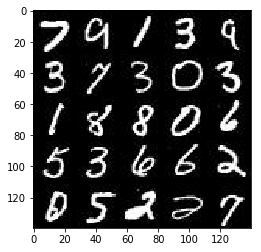

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  
Since you're going to be generating faces, you won't need the annotations. 
You can view the first number of examples by changing `show_n_images`.

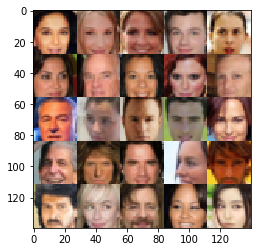

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  
The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. 
It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data).

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width --> 28
    :param image_height: The input image height --> 28
    :param image_channels: The number of image channels --> 3 RGB
    :param z_dim: The dimension of Z --> n
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # def model_inputs(real_dim, z_dim):
    #     real_size = (32,32,3)
    real_dim = (image_height, image_width, image_channels) # hxwxc
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name='input_real')

    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(dtype=tf.float32, shape=None, name='learning_rate')
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  
This function should be able to reuse the variabes in the neural network.
Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  
The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s) --> txwxhxc --> tx28x28x3
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # Implementation for DCGAN-svhn
    # def discriminator(x, reuse=False, alpha=0.2):
    alpha=0.2 # for leaky ReLU
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 32x32x3 -> 28x28x3 in this case
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(inputs=x1, training=True)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64 -> 14x14x64 with stride 2 ans same image

        x2 = tf.layers.conv2d(inputs=lrelu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(inputs=x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128 -> 7x7x128 with stride 2

        x3 = tf.layers.conv2d(inputs=lrelu2, filters=256, kernel_size=7, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(inputs=x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 -> 7x7x256 with stride 1 so NO change

        # Flatten it
        # 1st way
        #         flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.reshape(tensor=lrelu3, shape=(-1, 7*7*256), name=None)

        # 2nd way to flattening
        # Feedback tip
        #         Excellent work.
        #         You can flatten a layer with tf.contrib.layers.flatten() 
        #         check out: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten
        # flat = tf.contrib.layers.flatten(inputs=relu3)

        logits = tf.layers.dense(inputs=flat, units=1) # 1 output unit for 1, 0 or real/fake as the binary output
        out = tf.sigmoid(x=logits) # prob/confidence for one output/unit classification

        return out, logits

# # 2nd feedback tips     
# Most of the suggestions are same for both Generator and Discriminator.

# Discriminator
# 1- Using dropout in discriminator so that it is less prone to learning the data distribution.
# 2- Use custom weight initialization. Xavier init is proposed to work best when working with GANs.

# Generator
# 1- Try setting leak for leaky_relu a bit lower. Did you tried 0.1 ?
# 2- Try decreasing the width of layers from 512 -> 64. In context of GANs, 
# a sharp decline in number of filters for Generator helps produce better results.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. 
This function should be able to reuse the variabes in the neural network.  
Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. 
The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #     def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        #         x1 = tf.layers.dense(z, 4*4*512)
        # z is z_1x100=mat_txn, t/time/bacth, n/space/num_dim
        x1 = tf.layers.dense(inputs=z, units=7*7*512) # start from the last layer of discriminator/classifier/recognizer/perdictor
        # x1_1x7*7*512 -> 1x7x7x512

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(tensor=x1, shape=(-1, 7, 7, 512), name=None)
        bn1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now -> tx7x7x512, t=1 means one sample/record/image in each fwd/bwd prop/pass/path/route
        
        x2 = tf.layers.conv2d_transpose(inputs=lrelu1, filters=256, kernel_size=7, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now -> 7x7x256 with stride=1
        
        x3 = tf.layers.conv2d_transpose(inputs=lrelu2, filters=128, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now -> tx14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=lrelu3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 32x32x3 now -> tx28x28x3 the actual image size
        
        # prediction and regression -1, +1
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  
The function should return a tuple of (discriminator loss, generator loss).  
Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(z=input_z, out_channel_dim=out_channel_dim) # alpha is included inside
    d_model_real, d_logits_real = discriminator(images=input_real) # alpha included
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True) # alpha included

    d_loss_real = tf.reduce_mean(input_tensor= 
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(input_tensor=
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(input_tensor=
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

# 2nd feedback hints/tips
# The function model_loss is implemented correctly.
# Perfect.
# Now that was the trickiest part (and my personal favorite in GAN :)

# Tips

# 1- Use Label Smoothing for Discriminator loss, will help it generalize better. 
# If you have two target labels: Real=1 and Fake=0, then for each incoming sample, 
# if it is real, then replace the label with a random number between 0.7 and 1.2, 
# and if it is a fake sample, replace it with 0.0 and 0.3 (for example).

# 2- A simple change like labels = tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2) will help with 
# the training process. 
# This is known as label smoothing, typically used with classifiers to improve performance.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. 
Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  
The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  
Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. 
Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  
It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    # data_shape, e.g. mnist_dataset.shape == txhxwxc == shape== 0, 1, 2, 3
    input_real, input_z, lr = model_inputs(image_width=data_shape[1], 
                                                       image_height=data_shape[2], 
                                                      image_channels=data_shape[3], 
                                                      z_dim=z_dim)

    # Feedback tip
    # Great success has been shown if you wrap g_train_opt with
    # tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    # More details can be found here: http://ruishu.io/2016/12/27/batchnorm/
    # tf.control_dependencies() is used in the batch normalization lessons, 
    # and is necessary to get the normalization layers created
    # with tf.layers.batch_normalization to update their population statistics, 
    # which we need when performing inference.
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
        # train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
        d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])
        d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=lr, beta1=beta1)
    
    steps = 0 # for printing the generator output every 100 batches
    show_every = 100 # show the generated images
    print_every = 10 # printing out the loss for g and d
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            # batches_txn: t== number of minibatches, 
            # n== batch_size/ number of smaples/records/images in each minibatch
            for batch_images in get_batches(batch_size): 
                # TODO: Train Model
                
                # Feedback tip
                # Since the images are scaled to -0.5:0.5 and we are using tanh in the generator, 
                # you will likely see improved performance 
                # if you perform batch_images *= 2 in order to scale it to -1:1
                batch_images *= 2

                # for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # txn: t==batch_size, n==z_dim

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate}) # 1st time

                # Another tip, while not required, 
                # you can try to run the optimization for the generator twice --> g_opt
                # to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate}) # 2nd time

                # Feedback tip    
                # You're close! 
                # You may need to tune your discriminator and generator a bit, 
                # but first follow my advice below. 
                # Additionally, you should print the loss after each batch for both of your networks, 
                # that will give you some hints on what you need to change to get good output. 
                # For example, if your discriminator loss goes to zero, 
                # you know you may need to make your generator stronger, or 
                # run the optimizer for it again for each batch.
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z, lr: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "stpes: {:.4f}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show generator output every 100 minibatches training in each epoch
                # one epoch, t minibatches, each minibatch for training/updating the params in gnet and dnet
                if steps % show_every == 0:
                    show_n_images = 4 # nrows=5 , ncols=5, nrows*ncols=25 
                    show_generator_output(sess=sess, n_images=show_n_images, input_z=input_z, 
                                          out_channel_dim=data_shape[3], image_mode=data_image_mode)

### Setting up and fine-tuning the hyperparameters for both datasets

In [ ]:
# Hyperparameters for both dataset GANs training, valid, and testing
batch_size = 128
z_dim = 100
learning_rate = 0.0002 # 2/128 = 1/64
beta1 = 0.5

# The hyperparameters in DCGAN SVHN impl recom.
# real_size = (32,32,3) -> (28, 28, 3) in this case for both mnist and celebA datasets
# z_size = 100
# learning_rate = 0.0002
# batch_size = 128
# epochs = 25
# alpha = 0.2
# beta1 = 0.5

# 2nd feedback comments/hints/tips
# Given your network architecture, the choice of hyper-parameter are reasonable.
# Tips

# 1- You selected a good value for beta1. 
# Here's a good post explaining the importance of beta values and which value might be empirically better. 
# Also try lowering it even further, ~0.1 might even produce better results.

# 2- An important point to note is, batch size and learning rate are linked. 
# If the batch size is too small then the gradients will become more unstable and would need to 
# reduce the learning rate.
# Batch size used is on higher side. Try setting a value around 32/64.
# We know that larger batch sizes might speed up the training but can degrade the quality of the model at the same time. 
# This link might help you. 
# You can also read about this in the hyperparameters module in your classroom.

### MNIST
Test your GANs architecture on MNIST.  
After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  
Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... stpes: 10.0000... Discriminator Loss: 2.3972... Generator Loss: 0.3022
Epoch 1/2... stpes: 20.0000... Discriminator Loss: 4.7002... Generator Loss: 0.1693
Epoch 1/2... stpes: 30.0000... Discriminator Loss: 2.9876... Generator Loss: 0.0919
Epoch 1/2... stpes: 40.0000... Discriminator Loss: 2.9252... Generator Loss: 0.6181
Epoch 1/2... stpes: 50.0000... Discriminator Loss: 1.7298... Generator Loss: 0.6614
Epoch 1/2... stpes: 60.0000... Discriminator Loss: 1.7388... Generator Loss: 0.6019
Epoch 1/2... stpes: 70.0000... Discriminator Loss: 1.8916... Generator Loss: 0.4630
Epoch 1/2... stpes: 80.0000... Discriminator Loss: 1.9566... Generator Loss: 0.4590
Epoch 1/2... stpes: 90.0000... Discriminator Loss: 1.6833... Generator Loss: 0.4848
Epoch 1/2... stpes: 100.0000... Discriminator Loss: 1.5306... Generator Loss: 0.7045


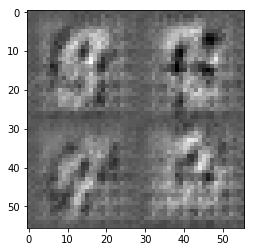

Epoch 1/2... stpes: 110.0000... Discriminator Loss: 1.5603... Generator Loss: 0.8013
Epoch 1/2... stpes: 120.0000... Discriminator Loss: 1.4753... Generator Loss: 1.0132
Epoch 1/2... stpes: 130.0000... Discriminator Loss: 1.5820... Generator Loss: 0.6238
Epoch 1/2... stpes: 140.0000... Discriminator Loss: 1.6641... Generator Loss: 0.4358
Epoch 1/2... stpes: 150.0000... Discriminator Loss: 1.7081... Generator Loss: 0.3661
Epoch 1/2... stpes: 160.0000... Discriminator Loss: 1.3227... Generator Loss: 0.6219
Epoch 1/2... stpes: 170.0000... Discriminator Loss: 1.2324... Generator Loss: 0.8702
Epoch 1/2... stpes: 180.0000... Discriminator Loss: 1.3833... Generator Loss: 1.1896
Epoch 1/2... stpes: 190.0000... Discriminator Loss: 1.3788... Generator Loss: 0.5973
Epoch 1/2... stpes: 200.0000... Discriminator Loss: 1.5466... Generator Loss: 1.3468


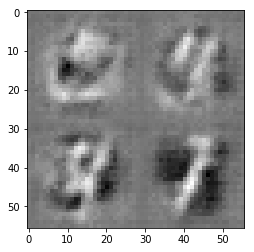

Epoch 1/2... stpes: 210.0000... Discriminator Loss: 1.2065... Generator Loss: 1.0198
Epoch 1/2... stpes: 220.0000... Discriminator Loss: 1.5513... Generator Loss: 1.0656
Epoch 1/2... stpes: 230.0000... Discriminator Loss: 1.3213... Generator Loss: 1.1033
Epoch 1/2... stpes: 240.0000... Discriminator Loss: 1.4839... Generator Loss: 1.1852
Epoch 1/2... stpes: 250.0000... Discriminator Loss: 1.4538... Generator Loss: 1.1992
Epoch 1/2... stpes: 260.0000... Discriminator Loss: 1.4229... Generator Loss: 1.0857
Epoch 1/2... stpes: 270.0000... Discriminator Loss: 1.4407... Generator Loss: 0.4294
Epoch 1/2... stpes: 280.0000... Discriminator Loss: 1.2938... Generator Loss: 0.6712
Epoch 1/2... stpes: 290.0000... Discriminator Loss: 1.6605... Generator Loss: 0.2894
Epoch 1/2... stpes: 300.0000... Discriminator Loss: 1.4411... Generator Loss: 0.4369


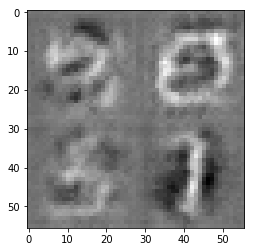

Epoch 1/2... stpes: 310.0000... Discriminator Loss: 1.4450... Generator Loss: 0.4911
Epoch 1/2... stpes: 320.0000... Discriminator Loss: 1.4425... Generator Loss: 0.4997
Epoch 1/2... stpes: 330.0000... Discriminator Loss: 1.5285... Generator Loss: 0.4348
Epoch 1/2... stpes: 340.0000... Discriminator Loss: 1.3527... Generator Loss: 0.6145
Epoch 1/2... stpes: 350.0000... Discriminator Loss: 1.8724... Generator Loss: 0.2446
Epoch 1/2... stpes: 360.0000... Discriminator Loss: 1.5223... Generator Loss: 0.6823
Epoch 1/2... stpes: 370.0000... Discriminator Loss: 1.4870... Generator Loss: 0.8921
Epoch 1/2... stpes: 380.0000... Discriminator Loss: 1.5168... Generator Loss: 0.7502
Epoch 1/2... stpes: 390.0000... Discriminator Loss: 1.2368... Generator Loss: 0.7332
Epoch 1/2... stpes: 400.0000... Discriminator Loss: 1.7012... Generator Loss: 0.2902


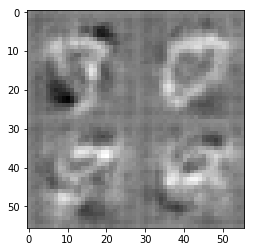

Epoch 1/2... stpes: 410.0000... Discriminator Loss: 1.3747... Generator Loss: 0.7748
Epoch 1/2... stpes: 420.0000... Discriminator Loss: 1.4448... Generator Loss: 0.4174
Epoch 1/2... stpes: 430.0000... Discriminator Loss: 1.3375... Generator Loss: 0.7076
Epoch 1/2... stpes: 440.0000... Discriminator Loss: 1.5854... Generator Loss: 0.3954
Epoch 1/2... stpes: 450.0000... Discriminator Loss: 1.3543... Generator Loss: 0.5314
Epoch 1/2... stpes: 460.0000... Discriminator Loss: 1.6012... Generator Loss: 0.3500
Epoch 2/2... stpes: 470.0000... Discriminator Loss: 1.4560... Generator Loss: 0.4191
Epoch 2/2... stpes: 480.0000... Discriminator Loss: 1.4711... Generator Loss: 0.5496
Epoch 2/2... stpes: 490.0000... Discriminator Loss: 1.4603... Generator Loss: 1.0341
Epoch 2/2... stpes: 500.0000... Discriminator Loss: 1.3604... Generator Loss: 0.8346


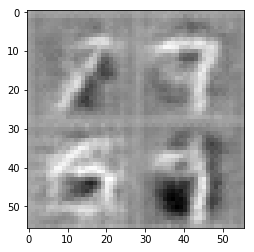

Epoch 2/2... stpes: 510.0000... Discriminator Loss: 1.4439... Generator Loss: 0.4503
Epoch 2/2... stpes: 520.0000... Discriminator Loss: 1.4025... Generator Loss: 0.4663
Epoch 2/2... stpes: 530.0000... Discriminator Loss: 1.3599... Generator Loss: 0.5665
Epoch 2/2... stpes: 540.0000... Discriminator Loss: 1.5330... Generator Loss: 0.3496
Epoch 2/2... stpes: 550.0000... Discriminator Loss: 1.4227... Generator Loss: 0.4503
Epoch 2/2... stpes: 560.0000... Discriminator Loss: 1.2815... Generator Loss: 0.6718
Epoch 2/2... stpes: 570.0000... Discriminator Loss: 1.5473... Generator Loss: 1.2964
Epoch 2/2... stpes: 580.0000... Discriminator Loss: 1.3768... Generator Loss: 0.6119
Epoch 2/2... stpes: 590.0000... Discriminator Loss: 1.4334... Generator Loss: 0.5012
Epoch 2/2... stpes: 600.0000... Discriminator Loss: 1.6404... Generator Loss: 1.2685


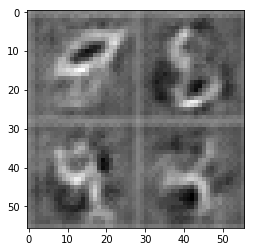

Epoch 2/2... stpes: 610.0000... Discriminator Loss: 1.3521... Generator Loss: 0.5510
Epoch 2/2... stpes: 620.0000... Discriminator Loss: 1.6675... Generator Loss: 0.2894
Epoch 2/2... stpes: 630.0000... Discriminator Loss: 1.3601... Generator Loss: 0.4744
Epoch 2/2... stpes: 640.0000... Discriminator Loss: 1.3072... Generator Loss: 0.7227
Epoch 2/2... stpes: 650.0000... Discriminator Loss: 1.4696... Generator Loss: 0.9792
Epoch 2/2... stpes: 660.0000... Discriminator Loss: 1.3541... Generator Loss: 0.9583
Epoch 2/2... stpes: 670.0000... Discriminator Loss: 1.3582... Generator Loss: 0.7612
Epoch 2/2... stpes: 680.0000... Discriminator Loss: 1.4421... Generator Loss: 0.5033
Epoch 2/2... stpes: 690.0000... Discriminator Loss: 1.3397... Generator Loss: 0.9597
Epoch 2/2... stpes: 700.0000... Discriminator Loss: 1.3600... Generator Loss: 0.7236


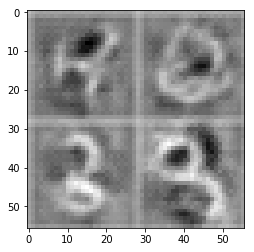

Epoch 2/2... stpes: 710.0000... Discriminator Loss: 1.3631... Generator Loss: 0.5192
Epoch 2/2... stpes: 720.0000... Discriminator Loss: 1.2936... Generator Loss: 0.6228
Epoch 2/2... stpes: 730.0000... Discriminator Loss: 1.3700... Generator Loss: 0.4243
Epoch 2/2... stpes: 740.0000... Discriminator Loss: 1.5516... Generator Loss: 0.3443
Epoch 2/2... stpes: 750.0000... Discriminator Loss: 1.2860... Generator Loss: 0.5401
Epoch 2/2... stpes: 760.0000... Discriminator Loss: 1.3396... Generator Loss: 0.7125
Epoch 2/2... stpes: 770.0000... Discriminator Loss: 1.7855... Generator Loss: 1.6602
Epoch 2/2... stpes: 780.0000... Discriminator Loss: 1.3455... Generator Loss: 0.4887
Epoch 2/2... stpes: 790.0000... Discriminator Loss: 1.6610... Generator Loss: 0.2781
Epoch 2/2... stpes: 800.0000... Discriminator Loss: 1.5399... Generator Loss: 0.3094


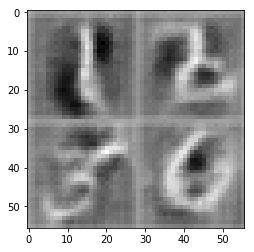

Epoch 2/2... stpes: 810.0000... Discriminator Loss: 1.3235... Generator Loss: 0.9358
Epoch 2/2... stpes: 820.0000... Discriminator Loss: 1.2550... Generator Loss: 0.7569
Epoch 2/2... stpes: 830.0000... Discriminator Loss: 1.4284... Generator Loss: 0.5468
Epoch 2/2... stpes: 840.0000... Discriminator Loss: 1.3424... Generator Loss: 0.7724
Epoch 2/2... stpes: 850.0000... Discriminator Loss: 1.3853... Generator Loss: 0.4634
Epoch 2/2... stpes: 860.0000... Discriminator Loss: 1.4179... Generator Loss: 0.9283
Epoch 2/2... stpes: 870.0000... Discriminator Loss: 1.4327... Generator Loss: 0.4313
Epoch 2/2... stpes: 880.0000... Discriminator Loss: 2.5075... Generator Loss: 2.0353
Epoch 2/2... stpes: 890.0000... Discriminator Loss: 1.4418... Generator Loss: 0.5427
Epoch 2/2... stpes: 900.0000... Discriminator Loss: 1.2379... Generator Loss: 0.8061


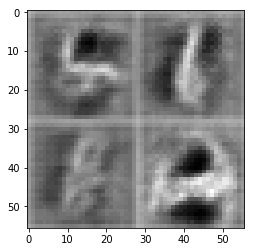

Epoch 2/2... stpes: 910.0000... Discriminator Loss: 1.2770... Generator Loss: 0.7277
Epoch 2/2... stpes: 920.0000... Discriminator Loss: 1.2504... Generator Loss: 0.7245
Epoch 2/2... stpes: 930.0000... Discriminator Loss: 1.4604... Generator Loss: 1.4499


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  
It will take around 20 minutes on the average GPU to run one epoch.  
You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... stpes: 10.0000... Discriminator Loss: 5.3516... Generator Loss: 0.0882
Epoch 1/1... stpes: 20.0000... Discriminator Loss: 4.2384... Generator Loss: 0.2784
Epoch 1/1... stpes: 30.0000... Discriminator Loss: 1.3770... Generator Loss: 1.7555
Epoch 1/1... stpes: 40.0000... Discriminator Loss: 1.9648... Generator Loss: 2.1596
Epoch 1/1... stpes: 50.0000... Discriminator Loss: 3.1968... Generator Loss: 0.4139
Epoch 1/1... stpes: 60.0000... Discriminator Loss: 2.4396... Generator Loss: 0.5253
Epoch 1/1... stpes: 70.0000... Discriminator Loss: 1.9945... Generator Loss: 0.6015
Epoch 1/1... stpes: 80.0000... Discriminator Loss: 2.2753... Generator Loss: 0.5509
Epoch 1/1... stpes: 90.0000... Discriminator Loss: 2.7549... Generator Loss: 0.3343
Epoch 1/1... stpes: 100.0000... Discriminator Loss: 2.5945... Generator Loss: 0.7383


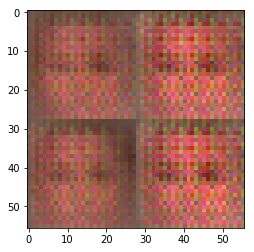

Epoch 1/1... stpes: 110.0000... Discriminator Loss: 1.4267... Generator Loss: 0.7584
Epoch 1/1... stpes: 120.0000... Discriminator Loss: 1.2590... Generator Loss: 0.8239
Epoch 1/1... stpes: 130.0000... Discriminator Loss: 2.7988... Generator Loss: 0.4044
Epoch 1/1... stpes: 140.0000... Discriminator Loss: 1.8777... Generator Loss: 0.4462
Epoch 1/1... stpes: 150.0000... Discriminator Loss: 1.6620... Generator Loss: 0.6455
Epoch 1/1... stpes: 160.0000... Discriminator Loss: 2.0082... Generator Loss: 0.5186
Epoch 1/1... stpes: 170.0000... Discriminator Loss: 1.5761... Generator Loss: 0.7431
Epoch 1/1... stpes: 180.0000... Discriminator Loss: 1.5418... Generator Loss: 0.6864
Epoch 1/1... stpes: 190.0000... Discriminator Loss: 1.5941... Generator Loss: 0.5790
Epoch 1/1... stpes: 200.0000... Discriminator Loss: 1.4986... Generator Loss: 0.6116


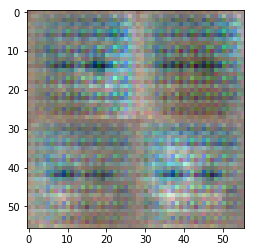

Epoch 1/1... stpes: 210.0000... Discriminator Loss: 1.6538... Generator Loss: 0.5858
Epoch 1/1... stpes: 220.0000... Discriminator Loss: 1.7239... Generator Loss: 0.5105
Epoch 1/1... stpes: 230.0000... Discriminator Loss: 1.6792... Generator Loss: 0.5627
Epoch 1/1... stpes: 240.0000... Discriminator Loss: 1.5402... Generator Loss: 0.6523
Epoch 1/1... stpes: 250.0000... Discriminator Loss: 1.5955... Generator Loss: 0.6183
Epoch 1/1... stpes: 260.0000... Discriminator Loss: 1.4952... Generator Loss: 0.6396
Epoch 1/1... stpes: 270.0000... Discriminator Loss: 1.4150... Generator Loss: 0.7010
Epoch 1/1... stpes: 280.0000... Discriminator Loss: 1.6025... Generator Loss: 0.6442
Epoch 1/1... stpes: 290.0000... Discriminator Loss: 1.3890... Generator Loss: 0.7127
Epoch 1/1... stpes: 300.0000... Discriminator Loss: 1.5551... Generator Loss: 0.6121


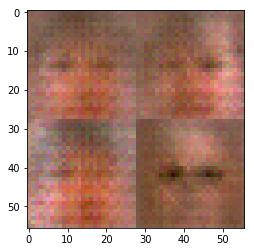

Epoch 1/1... stpes: 310.0000... Discriminator Loss: 1.3809... Generator Loss: 0.7558
Epoch 1/1... stpes: 320.0000... Discriminator Loss: 1.5456... Generator Loss: 0.6320
Epoch 1/1... stpes: 330.0000... Discriminator Loss: 1.4521... Generator Loss: 0.6500
Epoch 1/1... stpes: 340.0000... Discriminator Loss: 1.5006... Generator Loss: 0.6336
Epoch 1/1... stpes: 350.0000... Discriminator Loss: 1.5359... Generator Loss: 0.6175
Epoch 1/1... stpes: 360.0000... Discriminator Loss: 1.6481... Generator Loss: 0.6137
Epoch 1/1... stpes: 370.0000... Discriminator Loss: 1.5584... Generator Loss: 0.5847
Epoch 1/1... stpes: 380.0000... Discriminator Loss: 1.5331... Generator Loss: 0.6335
Epoch 1/1... stpes: 390.0000... Discriminator Loss: 1.5668... Generator Loss: 0.6787
Epoch 1/1... stpes: 400.0000... Discriminator Loss: 1.4361... Generator Loss: 0.6546


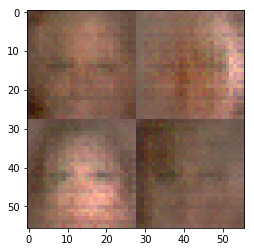

Epoch 1/1... stpes: 410.0000... Discriminator Loss: 1.6584... Generator Loss: 0.6208
Epoch 1/1... stpes: 420.0000... Discriminator Loss: 1.4958... Generator Loss: 0.6948
Epoch 1/1... stpes: 430.0000... Discriminator Loss: 1.6746... Generator Loss: 0.6148
Epoch 1/1... stpes: 440.0000... Discriminator Loss: 1.5237... Generator Loss: 0.6115
Epoch 1/1... stpes: 450.0000... Discriminator Loss: 1.6894... Generator Loss: 0.5709
Epoch 1/1... stpes: 460.0000... Discriminator Loss: 1.5014... Generator Loss: 0.6326
Epoch 1/1... stpes: 470.0000... Discriminator Loss: 1.4445... Generator Loss: 0.7446
Epoch 1/1... stpes: 480.0000... Discriminator Loss: 1.4477... Generator Loss: 0.6970
Epoch 1/1... stpes: 490.0000... Discriminator Loss: 1.6223... Generator Loss: 0.5859
Epoch 1/1... stpes: 500.0000... Discriminator Loss: 1.3781... Generator Loss: 0.6637


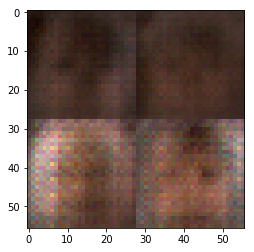

Epoch 1/1... stpes: 510.0000... Discriminator Loss: 1.5711... Generator Loss: 0.6332
Epoch 1/1... stpes: 520.0000... Discriminator Loss: 1.5291... Generator Loss: 0.6801
Epoch 1/1... stpes: 530.0000... Discriminator Loss: 1.5467... Generator Loss: 0.6418
Epoch 1/1... stpes: 540.0000... Discriminator Loss: 1.4584... Generator Loss: 0.6634
Epoch 1/1... stpes: 550.0000... Discriminator Loss: 1.5729... Generator Loss: 0.6576
Epoch 1/1... stpes: 560.0000... Discriminator Loss: 1.5144... Generator Loss: 0.6091
Epoch 1/1... stpes: 570.0000... Discriminator Loss: 1.4882... Generator Loss: 0.6590
Epoch 1/1... stpes: 580.0000... Discriminator Loss: 1.5112... Generator Loss: 0.6799
Epoch 1/1... stpes: 590.0000... Discriminator Loss: 1.5848... Generator Loss: 0.5923


In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.